## Training Your Model, and Using It to Clean Your 


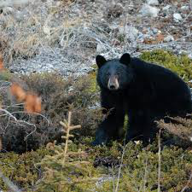

In [1]:
from fastai.vision.all import *
img =  PILImage.create('bears/black_bear/black_bear1.jpg')
img.to_thumb(192)


In [2]:
path = Path("bears")
fns = get_image_files(path)
fns

(#238) [Path('bears/black_bear/black_bear1.jpg'),Path('bears/black_bear/black_bear10.jpg'),Path('bears/black_bear/black_bear11.jpg'),Path('bears/black_bear/black_bear12.jpg'),Path('bears/black_bear/black_bear13.jpg'),Path('bears/black_bear/black_bear14.jpg'),Path('bears/black_bear/black_bear15.jpg'),Path('bears/black_bear/black_bear16.jpg'),Path('bears/black_bear/black_bear17.jpg'),Path('bears/black_bear/black_bear18.jpg')...]

In [3]:
#Checking weather some files were corrupted win the process of downloading
failed = verify_images(fns)
failed

(#0) []

In [4]:
bears = DataBlock(
 blocks=(ImageBlock, CategoryBlock), #Tuple specifying what we want for independent and dependent variable
 get_items=get_image_files, #Get urls of the downloded files
 splitter=RandomSplitter(valid_pct=0.2, seed=42), #Splits the downloaded dataset into training and validation data
 get_y=parent_label, #Labeling the idependent variable using the folder name in which our example is in it
 item_tfms=Resize(128)) #This transforms the images within a tensor into one specific pixel size

Due to IPython and Windows limitation, python multiprocessing isn't available now.
So `number_workers` is changed to 0 to avoid getting stuck


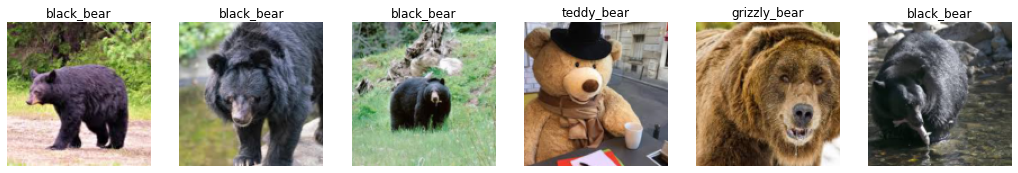

In [5]:
dls = bears.dataloaders(path)

dls.valid.show_batch(max_n=6, nrows=1)


Due to IPython and Windows limitation, python multiprocessing isn't available now.
So `number_workers` is changed to 0 to avoid getting stuck


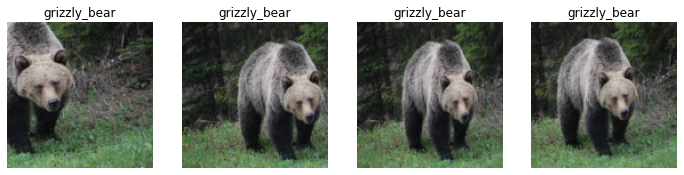

In [6]:
bears = bears.new(item_tfms=RandomResizedCrop(128, min_scale=0.3)) #RandomResizeCrop - Objects are in slightly different positions and of different sizes to enable the model to have a better understanding o what a model is
dls = bears.dataloaders(path)
dls.train.show_batch(max_n=4, nrows=1, unique=True)


Due to IPython and Windows limitation, python multiprocessing isn't available now.
So `number_workers` is changed to 0 to avoid getting stuck


C:\Users\ProgrammingOperative\anaconda3\lib\site-packages\torch\_tensor.py:1023: UserWarning: torch.solve is deprecated in favor of torch.linalg.solveand will be removed in a future PyTorch release.
torch.linalg.solve has its arguments reversed and does not return the LU factorization.
To get the LU factorization see torch.lu, which can be used with torch.lu_solve or torch.lu_unpack.
X = torch.solve(B, A).solution
should be replaced with
X = torch.linalg.solve(A, B) (Triggered internally at  ..\aten\src\ATen\native\BatchLinearAlgebra.cpp:760.)
  ret = func(*args, **kwargs)


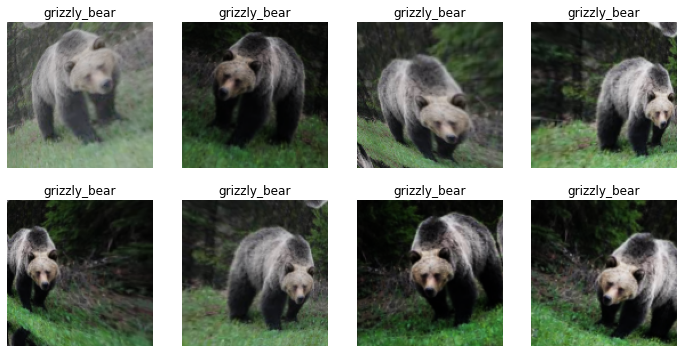

In [7]:
bears = bears.new(item_tfms=Resize(128),
batch_tfms=aug_transforms(mult=2))
dls = bears.dataloaders(path)
dls.train.show_batch(max_n=8, nrows=2, unique=True)


### TRAINING MY MODEL AND USING IT TO CLEAN MY DATA

In [8]:
bears = bears.new(
 item_tfms=RandomResizedCrop(224, min_scale=0.5),
 batch_tfms=aug_transforms())
dls = bears.dataloaders(path)

Due to IPython and Windows limitation, python multiprocessing isn't available now.
So `number_workers` is changed to 0 to avoid getting stuck


In [9]:
#Creating a CNN learner

learn = cnn_learner(dls, resnet18, metrics = error_rate)
learn.fine_tune(4)

C:\Users\ProgrammingOperative\anaconda3\lib\site-packages\torch\nn\functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  ..\c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


epoch,train_loss,valid_loss,error_rate,time
0,1.909506,1.457653,0.489362,01:45


epoch,train_loss,valid_loss,error_rate,time
0,0.949801,0.597841,0.361702,01:22
1,0.691242,0.189298,0.042553,01:20
2,0.522097,0.135797,0.042553,01:15
3,0.410495,0.100227,0.042553,01:12


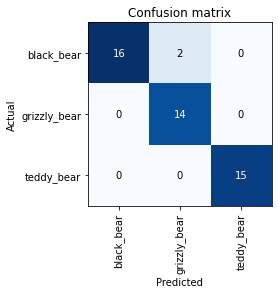

In [10]:
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix()

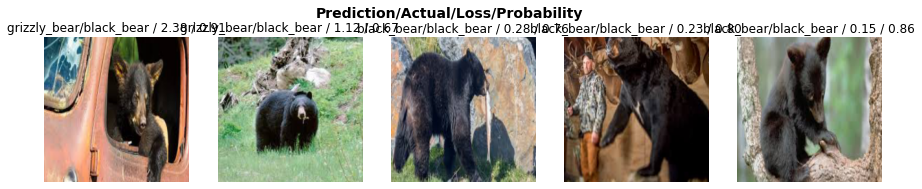

In [11]:
interp.plot_top_losses(5, nrows = 1)

In [12]:
from fastai.vision.widgets import *
cleaner = ImageClassifierCleaner(learn) #This class allows us to view the images with the highest loss along with the menus to allow for those images to be selected for relabelling or removal
cleaner

In [13]:
for idx in cleaner.delete(): cleaner.fns[idx].unlink() #The ImageClassifierCleaner class only returns the index of the selected
                                                        #images therefore we have to actually delete it as illustrated here

In [14]:
for idx,cat in cleaner.change(): shutil.move(str(cleaner.fns[idx]), path/cat) # Moving images for which we have selected a different category

### TURNING THE MODEL INTO AN ONLINE APPLICATION


In [15]:
'''Export method - Saves both the parameter and architecture of our learner model.The easiest way
to save a model is by saving the both of these. The saved model can then be copied to a server
that can then be used in production

When you call export, fastai will save a file called 'export.pkl'
'''
learn.export()

In [16]:
'''
Checking that the file exists, by using the ls method that fastai adds to Python’s
Path class:'''
path = Path()
path.ls(file_exts='.pkl')


(#1) [Path('export.pkl')]

In [17]:
path

Path('.')

In [18]:
'''
When we use a model for getting predictions, instead of training, we call it
inference. To create our inference learner from the exported file, we use
load_learner 

learn_inf will be used used in the actual production - already Loaded into the server using 
'load_learner' '''

learn_inf = load_learner(path/'export.pkl') 
pth = Path("test_bear")
learn_inf.predict(pth/'black_bea.jpg')

('black_bear', tensor(0), tensor([9.9942e-01, 5.1358e-04, 6.9960e-05]))

In [19]:
#'vocab' - stored list List of all possible categories
# At inference time, you can access the DataLoaders as an attribute of the learner i.e learn_inf
the Learner
learn_inf.dls.vocab

['black_bear', 'grizzly_bear', 'teddy_bear']